In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [2]:
# Load your data
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_with_hypotheses.csv'
df = pd.read_csv(file_path)
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,hypothesis
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...,H0
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...,H2
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...,H2
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...,H2
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...,H4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583766,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,H1
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented,H2
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...,H2
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...,H2


In [3]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def vader_sentiment(text):
    return analyzer.polarity_scores(text)

In [4]:
column_for_sentiment = 'thread_text_processed'

In [5]:
tqdm.pandas(desc="Processing")
df['compound'] = df['thread_text_processed'].progress_apply(vader_sentiment).progress_apply(lambda x: x['compound'])
# df['compound'] = df['vader_sentiment'].apply(lambda x: x['compound'])
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

Processing: 100%|██████████| 583771/583771 [00:00<00:00, 1021312.95it/s]


In [6]:
print("Sentiment Counts:\n", df['sentiment'].value_counts())

# print("thread_text_processed_sentiment Counts:\n", df['thread_text_processed_sentiment'].value_counts())
# print("combined_processed_sentiment Counts:\n", df['combined_processed_sentiment'].value_counts())
# print("thread_text_processed_vader_sentiment Counts:\n", df['thread_text_processed_vader_sentiment'].value_counts())
# print("combined_processed_vader_sentiment Counts:\n", df['combined_processed_vader_sentiment'].value_counts())

Sentiment Counts:
 sentiment
positive    254118
negative    224184
neutral     105469
Name: count, dtype: int64


In [7]:
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_final.csv', index=False)

# H0: Personal experiences with surveillance cameras significantly shape people's views on public monitoring.
# H1: Attitudes toward surveillance cameras vary significantly depending on their placement in different settings, such as shopping areas, residential blocks, and workplaces.
# H2: There are common technical complaints about surveillance cameras, and people suggest specific enhancements to address these issues.
# H3: Surveillance cameras make people feel more secure rather than feeling watched.
# H4: There is a noticeable relationship between the density of surveillance cameras in an area and public opinion regarding their presence.

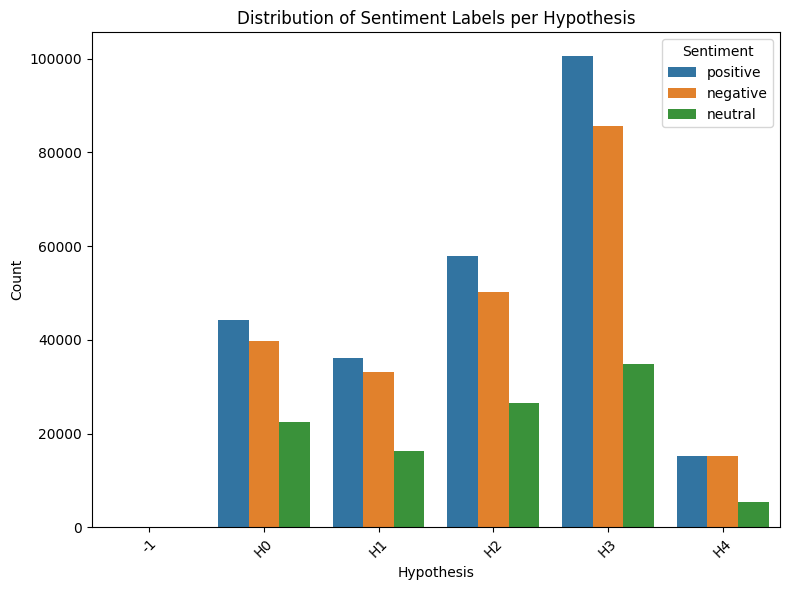

In [8]:
# Plot the distribution of sentiment labels for each hypothesis in a single graph
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='hypothesis', hue='sentiment', order=sorted(df['hypothesis'].unique()))
plt.title('Distribution of Sentiment Labels per Hypothesis')
plt.xlabel('Hypothesis')
plt.ylabel('Count')
plt.legend(title='Sentiment', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# # Get unique hypotheses
# hypotheses = df['combined_hypothesis'].unique()

# # Plot the distribution of sentiment labels for each hypothesis
# for hypothesis in hypotheses:
#     subset = df[df['combined_hypothesis'] == hypothesis]
#     plt.figure(figsize=(10, 6))
#     sns.countplot(data=subset, x='sentiment', order=['positive', 'neutral', 'negative'])
#     plt.title(f'Distribution of Sentiment Labels for Hypothesis {hypothesis}')
#     plt.xlabel('Sentiment')
#     plt.ylabel('Count')
#     plt.show()

In [9]:
# Display some example rows for each sentiment
positive_examples = df[df['sentiment'] == 'positive'].sample(10)
neutral_examples = df[df['sentiment'] == 'neutral'].sample(10)
negative_examples = df[df['sentiment'] == 'negative'].sample(10)

print("Positive Examples:\n", positive_examples[['thread_text_processed']])
print("\nNeutral Examples:\n", neutral_examples[['thread_text_processed']])
print("\nNegative Examples:\n", negative_examples[['thread_text_processed']])

Positive Examples:
                                     thread_text_processed
259248  clearly us forces are acting to preserve us in...
439209  agreed but i still offer that as an option bec...
281359  sounds like you need to pack up and get the he...
478790  netflix will allow you to stream star trek tng...
459954  i think he is referring to  it is still in bet...
376811  i like politician x can i give politician x a ...
302911  i do not think that would apply here unless th...
125610             this is the best one amazingly written
113343  i do not give a shit about government surveill...
299437  you are welcome and as the disorders mentioned...

Neutral Examples:
                                     thread_text_processed
362317        the ultimate test of a beer drinkers mettle
39832                                       i second this
362382  ive heard a lot of gangs hang out at six flags...
418627         ah ok no qualms with sms not being private
392627  one thing this does noto

In [ ]:
# yearly trend of hypothesis/ evolution
# key and dominant entities occuring in sentiment types
# research the reason of starting point of heated discussions
# evolution of camera implementations/ legislation frameword/ public camera installations / accidents

C:\Users\fahad\AppData\Local\Temp\ipykernel_32752\918555014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year


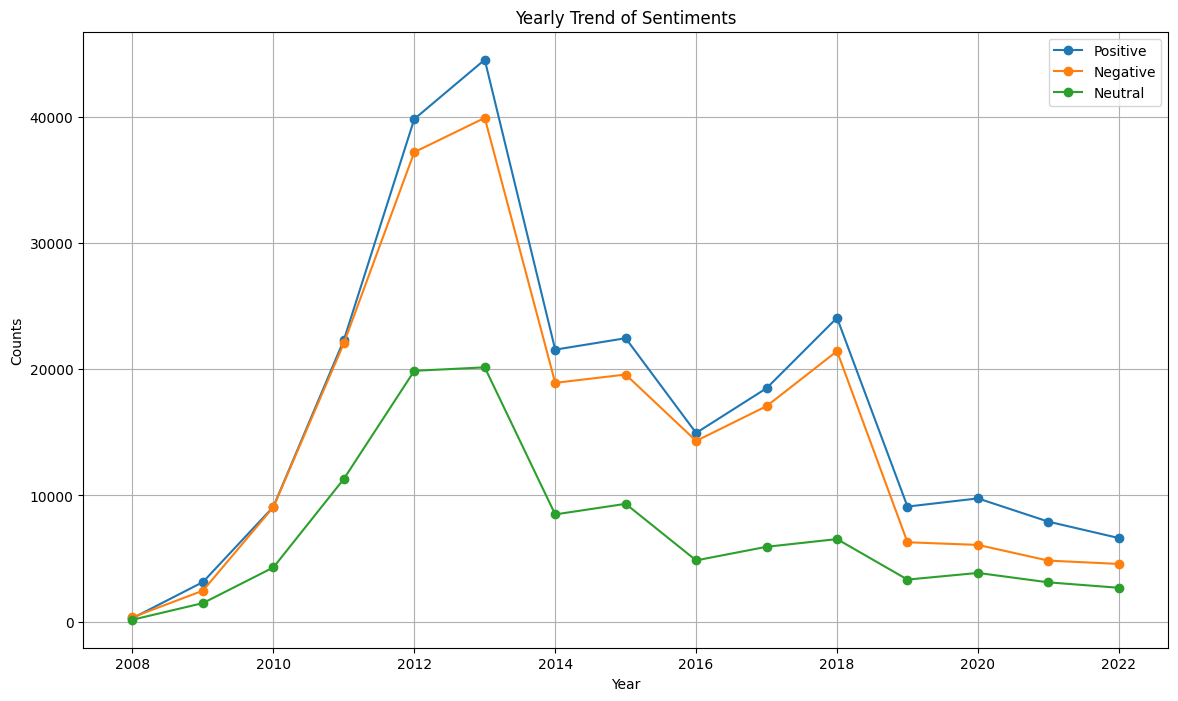

In [10]:
# Filter out rows with hypothesis '-1'
df_filtered = df[df['hypothesis'] != '-1']

# Convert datetime to datetime format and extract year
df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year

# Group by year and sentiment
yearly_sentiment = df_filtered.groupby(['year', 'sentiment']).size().reset_index(name='counts')

# Pivot the table
yearly_sentiment_pivot = yearly_sentiment.pivot_table(index='year', columns='sentiment', values='counts', fill_value=0)

# Plot yearly trend for all sentiments
plt.figure(figsize=(14, 8))
if 'positive' in yearly_sentiment_pivot.columns:
    plt.plot(yearly_sentiment_pivot.index, yearly_sentiment_pivot['positive'], marker='o', label='Positive')
if 'negative' in yearly_sentiment_pivot.columns:
    plt.plot(yearly_sentiment_pivot.index, yearly_sentiment_pivot['negative'], marker='o', label='Negative')
if 'neutral' in yearly_sentiment_pivot.columns:
    plt.plot(yearly_sentiment_pivot.index, yearly_sentiment_pivot['neutral'], marker='o', label='Neutral')

plt.title('Yearly Trend of Sentiments')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()


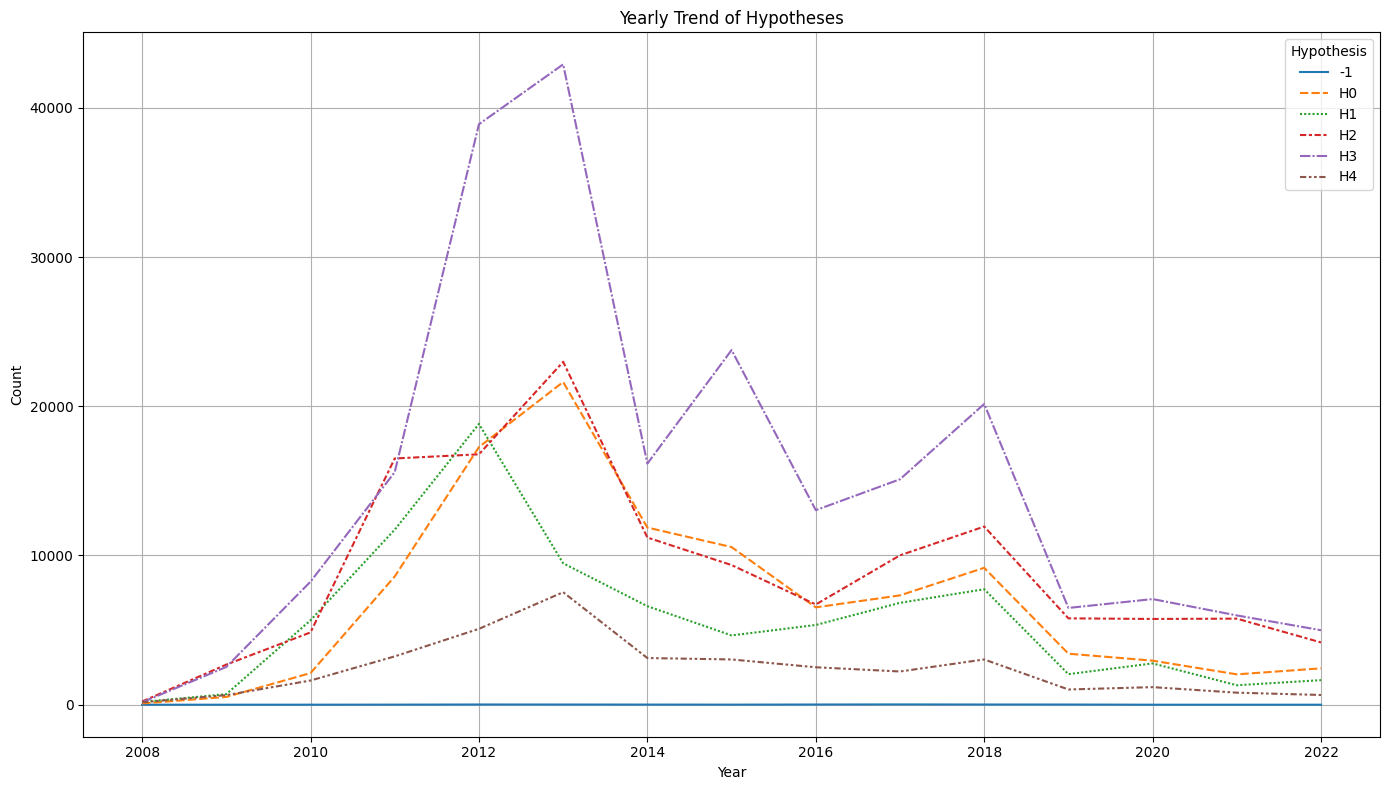

In [11]:
# Ensure 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year

# Count the occurrences of each hypothesis per year
yearly_hypothesis_counts = df.groupby(['year', 'hypothesis']).size().reset_index(name='counts')

# Pivot the table to get hypotheses as columns
yearly_hypothesis_pivot = yearly_hypothesis_counts.pivot(index='year', columns='hypothesis', values='counts').fillna(0)

# Plot the yearly trend of each hypothesis
plt.figure(figsize=(14, 8))
sns.lineplot(data=yearly_hypothesis_pivot)
plt.title('Yearly Trend of Hypotheses')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Hypothesis', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\fahad\AppData\Local\Temp\ipykernel_32752\4290970752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year


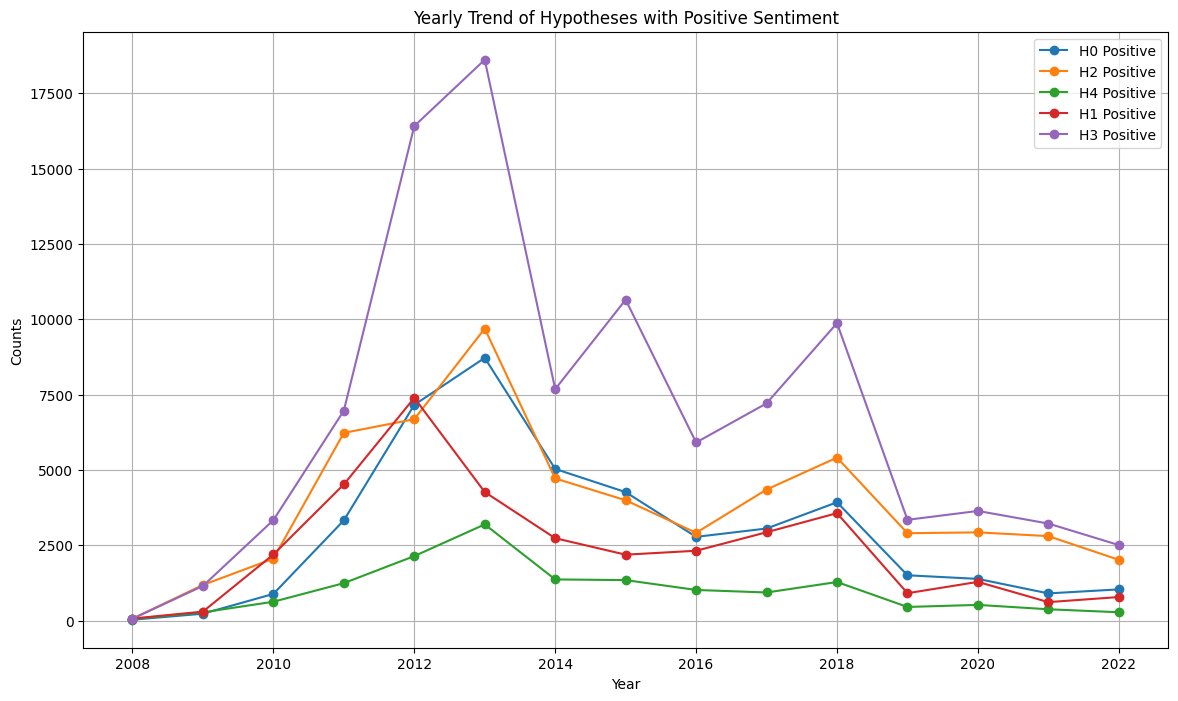

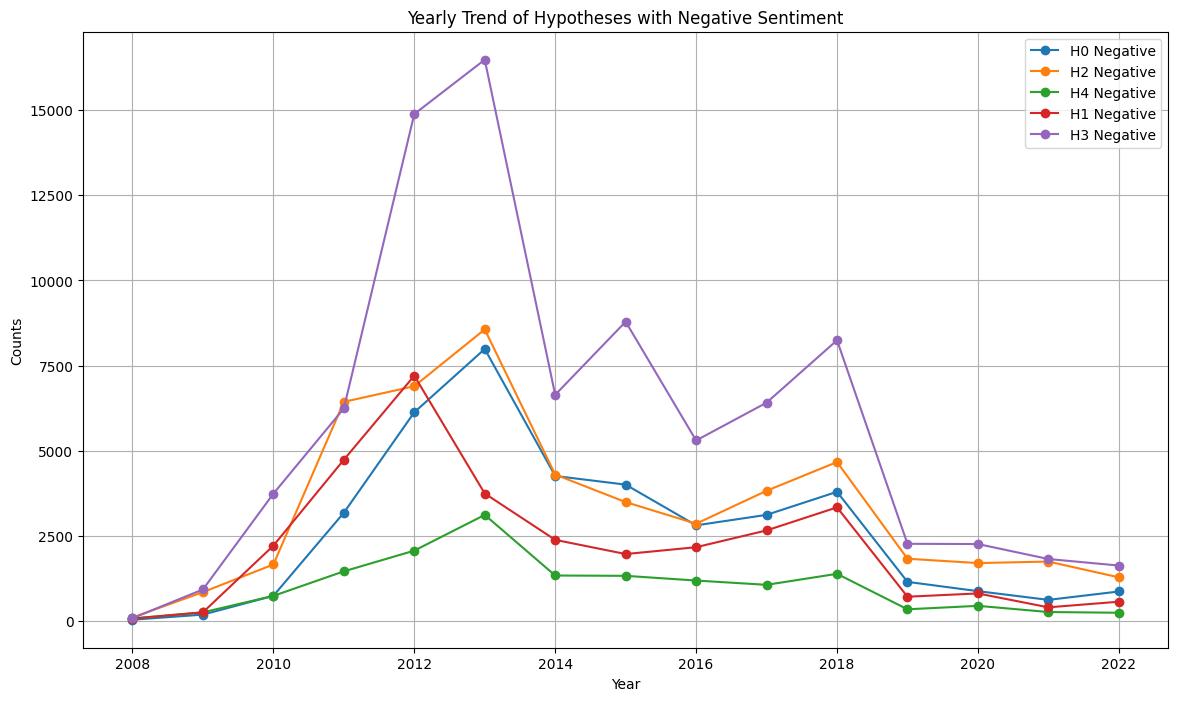

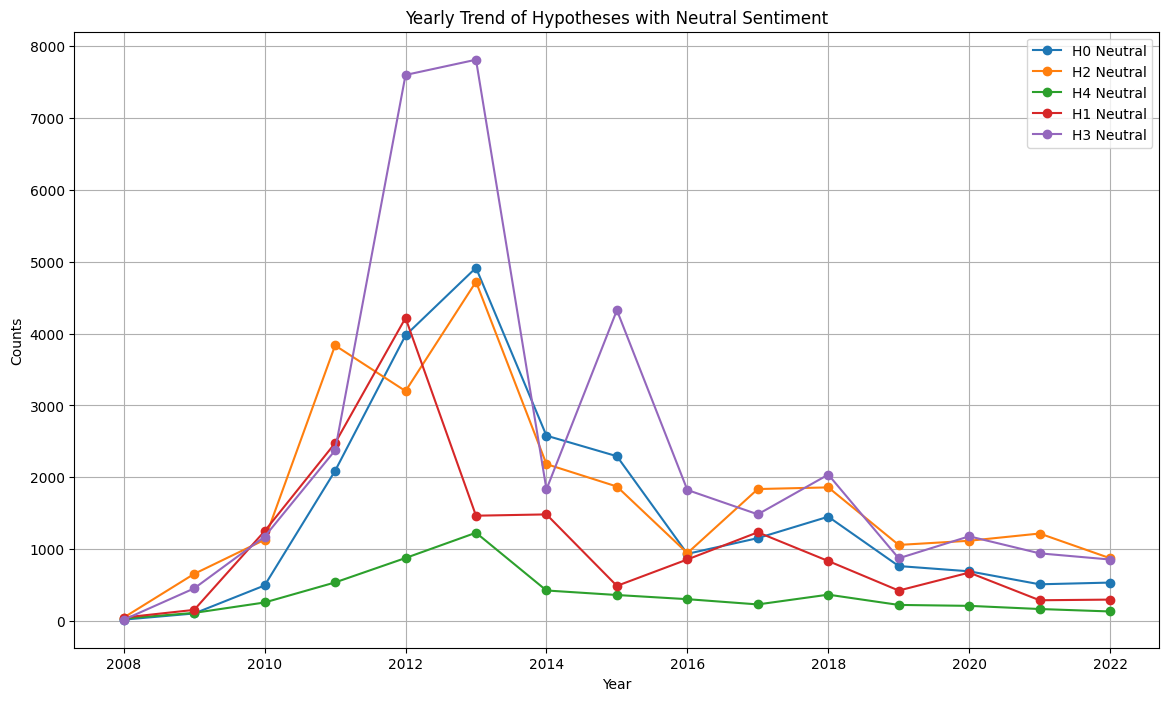

In [12]:
# Filter out rows with hypothesis '-1'
df_filtered = df[df['hypothesis'] != '-1']

# Convert datetime to datetime format and extract year
df_filtered['year'] = pd.to_datetime(df_filtered['datetime']).dt.year

# Group by year, hypothesis, and sentiment
yearly_hypothesis_sentiment = df_filtered.groupby(['year', 'hypothesis', 'sentiment']).size().reset_index(name='counts')

# Pivot the table
yearly_hypothesis_sentiment_pivot = yearly_hypothesis_sentiment.pivot_table(index='year', columns=['hypothesis', 'sentiment'], values='counts', fill_value=0)

# Plot positive sentiment
plt.figure(figsize=(14, 8))
for hypothesis in df_filtered['hypothesis'].unique():
    if 'positive' in yearly_hypothesis_sentiment_pivot[hypothesis].columns:
        plt.plot(yearly_hypothesis_sentiment_pivot.index, yearly_hypothesis_sentiment_pivot[hypothesis]['positive'], marker='o', label=f'{hypothesis} Positive')

plt.title('Yearly Trend of Hypotheses with Positive Sentiment')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot negative sentiment
plt.figure(figsize=(14, 8))
for hypothesis in df_filtered['hypothesis'].unique():
    if 'negative' in yearly_hypothesis_sentiment_pivot[hypothesis].columns:
        plt.plot(yearly_hypothesis_sentiment_pivot.index, yearly_hypothesis_sentiment_pivot[hypothesis]['negative'], marker='o', label=f'{hypothesis} Negative')

plt.title('Yearly Trend of Hypotheses with Negative Sentiment')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot neutral sentiment
plt.figure(figsize=(14, 8))
for hypothesis in df_filtered['hypothesis'].unique():
    if 'neutral' in yearly_hypothesis_sentiment_pivot[hypothesis].columns:
        plt.plot(yearly_hypothesis_sentiment_pivot.index, yearly_hypothesis_sentiment_pivot[hypothesis]['neutral'], marker='o', label=f'{hypothesis} Neutral')

plt.title('Yearly Trend of Hypotheses with Neutral Sentiment')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.legend(loc='best')
plt.grid(True)
plt.show()


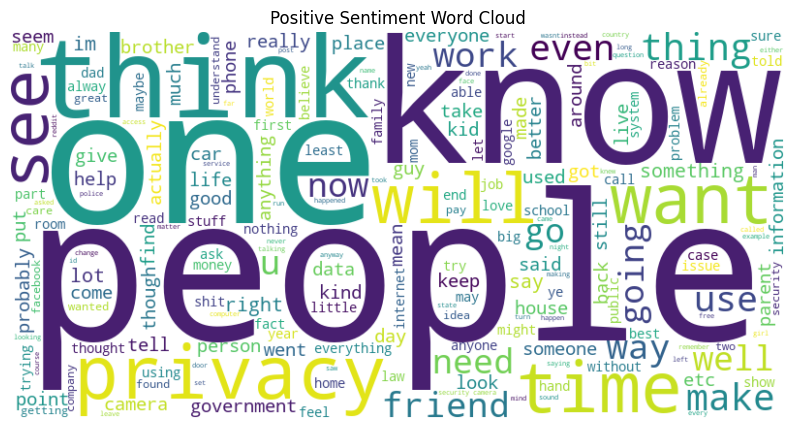

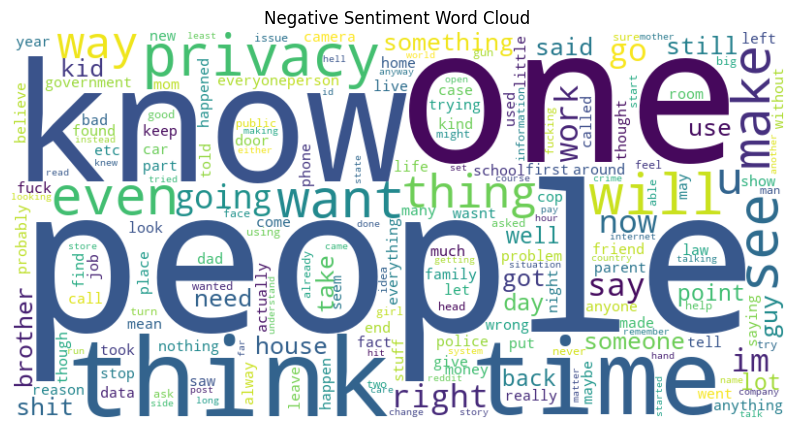

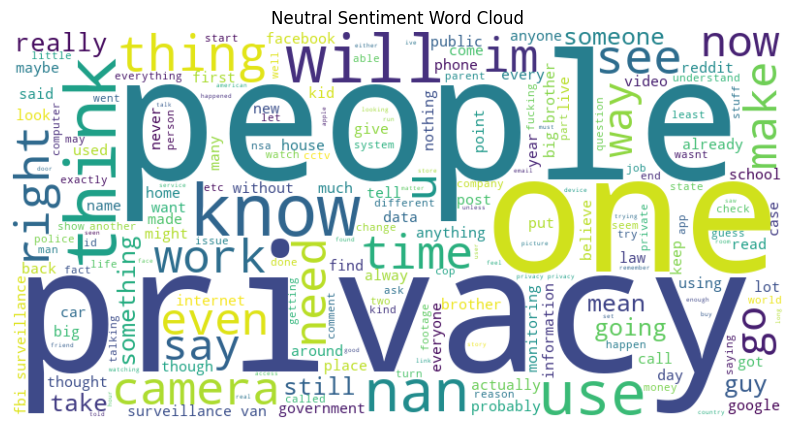

In [14]:
# Generate word clouds for each sentiment type
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Filter the texts by sentiment
positive_text = df[df['sentiment'] == 'positive']['thread_text_processed']
negative_text = df[df['sentiment'] == 'negative']['thread_text_processed']
neutral_text = df[df['sentiment'] == 'neutral']['thread_text_processed']

# Generate word clouds
generate_word_cloud(positive_text, 'Positive Sentiment Word Cloud')
generate_word_cloud(negative_text, 'Negative Sentiment Word Cloud')
generate_word_cloud(neutral_text, 'Neutral Sentiment Word Cloud')


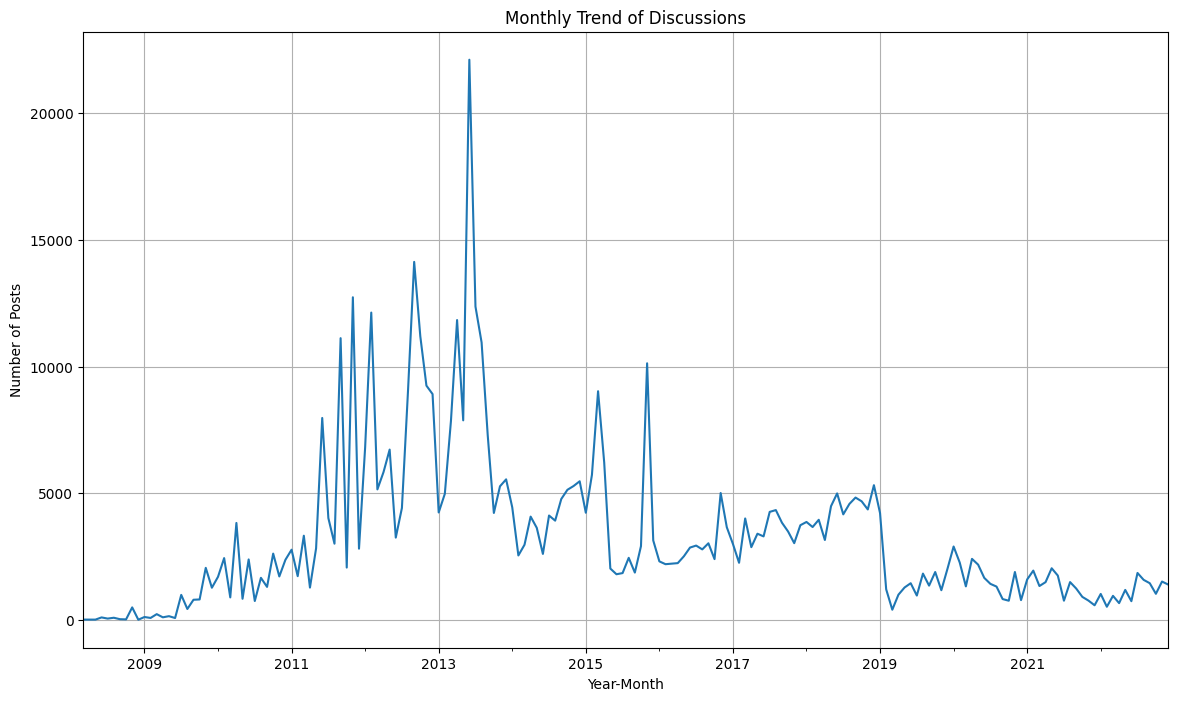

Top 10 months with highest increase in posts:
year_month
2013-06    14235.0
2011-11    10669.0
2011-09     8112.0
2015-11     7217.0
2012-02     5328.0
2011-06     5145.0
2012-09     5065.0
2012-08     4650.0
2012-01     3992.0
2013-04     3982.0
Freq: M, Name: count, dtype: float64


In [15]:
# Group by year and month to see trends over time
df['year_month'] = pd.to_datetime(df['datetime']).dt.to_period('M')
monthly_counts = df['year_month'].value_counts().sort_index()

plt.figure(figsize=(14, 8))
monthly_counts.plot()
plt.title('Monthly Trend of Discussions')
plt.xlabel('Year-Month')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

# Find months with the highest increase in posts
monthly_counts_diff = monthly_counts.diff().dropna()
top_increases = monthly_counts_diff.nlargest(10)

print("Top 10 months with highest increase in posts:")
print(top_increases)
